In [58]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2,SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import  pickle
import unicodedata
import codecs
from string import punctuation
%matplotlib inline

In [34]:
df = pd.read_csv('data/annotation.csv')
print(df.columns)
df.head()

Index(['text', 'relation'], dtype='object')


,text,relation
0,PKB directly phosphorylates DAF-16 / FOXO and ...,1
1,PKB directly phosphorylates DAF-16 / FOXO and ...,1
2,The fact that Tax1 interacts with ATFx adds an...,0
3,Nuclear import and export of Tax1 are both car...,0
4,NF-kappaB activation involves phosphorylation ...,0


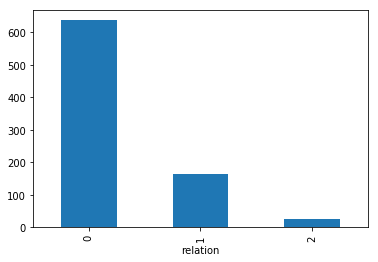

In [28]:
df.groupby('relation').text.count().plot.bar(ylim=0)
plt.show()

In [44]:
def TextPreprocessing(text):
    stemmer = WordNetLemmatizer()
#     stemmer = PorterStemmer()
    text = text.lower()
    def strip_punctuation(s):
        return ''.join(c for c in s if c not in punctuation)
    def unicodeToAscii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')           
    def normalizeString(s):
        s = unicodeToAscii(s.lower().strip())
        #remove numbers
#         s = re.sub(r'\d+', '', s)
        # remove all single characters
        s = re.sub(r'\s+[a-zA-Z]\s+', ' ', s)
        # Remove single characters from the start
        s = re.sub(r'\^[a-zA-Z]\s+', ' ', s) 
        # Substituting multiple spaces with single space
        s = re.sub(r'\s+', ' ', s, flags=re.I)
        # Removing prefixed 'b'
        s = re.sub(r'^b\s+', '', s)
        # Lemmatization
        s = s.split()
        s = [stemmer.lemmatize(word) for word in s]
#         s = [stemmer.stem(word) for word in s]
        s = ' '.join(s)
#         s =  strip_punctuation(s)
        return s
    
    doc = normalizeString(text)
    return doc


In [45]:
df['cleaned'] = df['text'].apply(TextPreprocessing)
df.head()

,text,relation,cleaned
0,PKB directly phosphorylates DAF-16 / FOXO and ...,1,pkb directly phosphorylates daf-16 / foxo and ...
1,PKB directly phosphorylates DAF-16 / FOXO and ...,1,pkb directly phosphorylates daf-16 / foxo and ...
2,The fact that Tax1 interacts with ATFx adds an...,0,the fact that tax1 interacts with atfx add ano...
3,Nuclear import and export of Tax1 are both car...,0,nuclear import and export of tax1 are both car...
4,NF-kappaB activation involves phosphorylation ...,0,nf-kappab activation involves phosphorylation ...


In [51]:
vectorizer = TfidfVectorizer(min_df=3,stop_words='english',sublinear_tf=True,norm='l2', 
                                 ngram_range=(1,3))
def featureExtractor(data):    
    final_features = vectorizer.fit_transform(data).toarray()
    return final_features
ff = featureExtractor(df['cleaned'])
ff.shape

(827, 3915)

In [49]:
X = df['cleaned']
Y = df['relation']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = .25,random_state=123,stratify=Y)

In [61]:
pipeline = Pipeline([('vect',vectorizer),
                    ('chi', SelectKBest(chi2,k=1200)),
                    ('clf',RandomForestClassifier())])
model = pipeline.fit(X_train,Y_train)
with open('RandomForest.pickle','wb') as f:
    pickle.dump(model,f)
Ytest = np.array(Y_test)
print(classification_report(Ytest,model.predict(X_test)))
print(confusion_matrix(Ytest, model.predict(X_test)))
print('F1Score is: ', f1_score(Ytest, model.predict(X_test),labels=[1,2],average='micro' ))
print('Precision is: ', precision_score(Ytest, model.predict(X_test),labels=[1,2],average='micro' ))
print('Recall: ', recall_score(Ytest, model.predict(X_test),labels=[1,2],average='micro' ))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       159
           1       0.42      0.24      0.31        41
           2       0.00      0.00      0.00         7

   micro avg       0.75      0.75      0.75       207
   macro avg       0.41      0.39      0.39       207
weighted avg       0.70      0.75      0.72       207

[[146  13   0]
 [ 30  10   1]
 [  6   1   0]]
F1Score is:  0.273972602739726
Precision is:  0.4
Recall:  0.20833333333333334


/home/akkasi/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [67]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import metrics
scores = cross_val_score(model, X, Y, cv=10)
print ('Cross-validated scores:', scores)


Cross-validated scores: [0.8452381  0.75       0.72619048 0.75903614 0.71084337 0.73493976
 0.72289157 0.75308642 0.71604938 0.74074074]


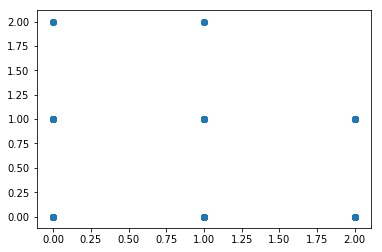

In [68]:
predictions = cross_val_predict(model, X, Y, cv=10)
plt.scatter(Y, predictions)

In [73]:
f1_score = metrics.f1_score(Y, predictions,average='micro',labels=[1,2])
f1_score

0.21739130434782608